# TASK 2
Predict admission to general ward, semi-intensive unit or intensive care unit among confirmed COVID-19 cases.



Steps:

Import Data

Exploratory Data Analysis

Data Preparation + Feature Enginnering

Split data in train and test

Test some Machine Learning models

Tuning hiper-parameters using Random Search

Choose the best model

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
import re
import shap
from skopt import dummy_minimize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
#Read dataframe
df = pd.read_excel("../input/covid19/dataset.xlsx")
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Define target 
df['ward_semi_intensive'] = np.where(df['Patient addmited to regular ward (1=yes, 0=no)']
                          + df['Patient addmited to semi-intensive unit (1=yes, 0=no)']
                          + df['Patient addmited to intensive care unit (1=yes, 0=no)']>=1,1,0)

df = df.drop(['Patient addmited to regular ward (1=yes, 0=no)','Patient addmited to semi-intensive unit (1=yes, 0=no)','Patient addmited to intensive care unit (1=yes, 0=no)','Patient ID'], axis = 1)

In [4]:
#Filter columns with percentage of null >= 99%
df_missing = (df.isna().sum()/len(df)).to_frame()
df_missing =df_missing.rename(columns={0: 'percentage of null'})
print(df_missing[df_missing['percentage of null'] >0.99])

#Drop columns
drop = list(df_missing[df_missing['percentage of null'] >0.99].index)
df = df.drop(drop, axis = 1)

                                           percentage of null
Mycoplasma pneumoniae                                1.000000
Ionized calcium                                      0.991141
Magnesium                                            0.992913
Fio2 (venous blood gas analysis)                     0.999823
Urine - Nitrite                                      0.999823
Urine - Sugar                                        1.000000
Partial thromboplastin time (PTT)                    1.000000
Prothrombin time (PT), Activity                      1.000000
Vitamin B12                                          0.999468
Ferritin                                             0.995925
Arterial Lactic Acid                                 0.995216
Lipase dosage                                        0.998583
D-Dimer                                              1.000000
Albumin                                              0.997697
Hb saturation (arterial blood gases)                 0.995216
pCO2 (ar

# Exploratory Data Analysis

## Plotting target distribution   

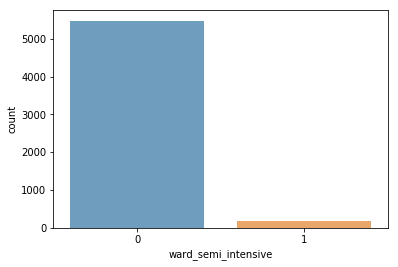

In [5]:
#Target variable
sns.countplot(x=df['ward_semi_intensive'], alpha=0.7, data=df)

# Plotting the distribution of numerics features  

Data must have variance to compute a kernel density estimate.


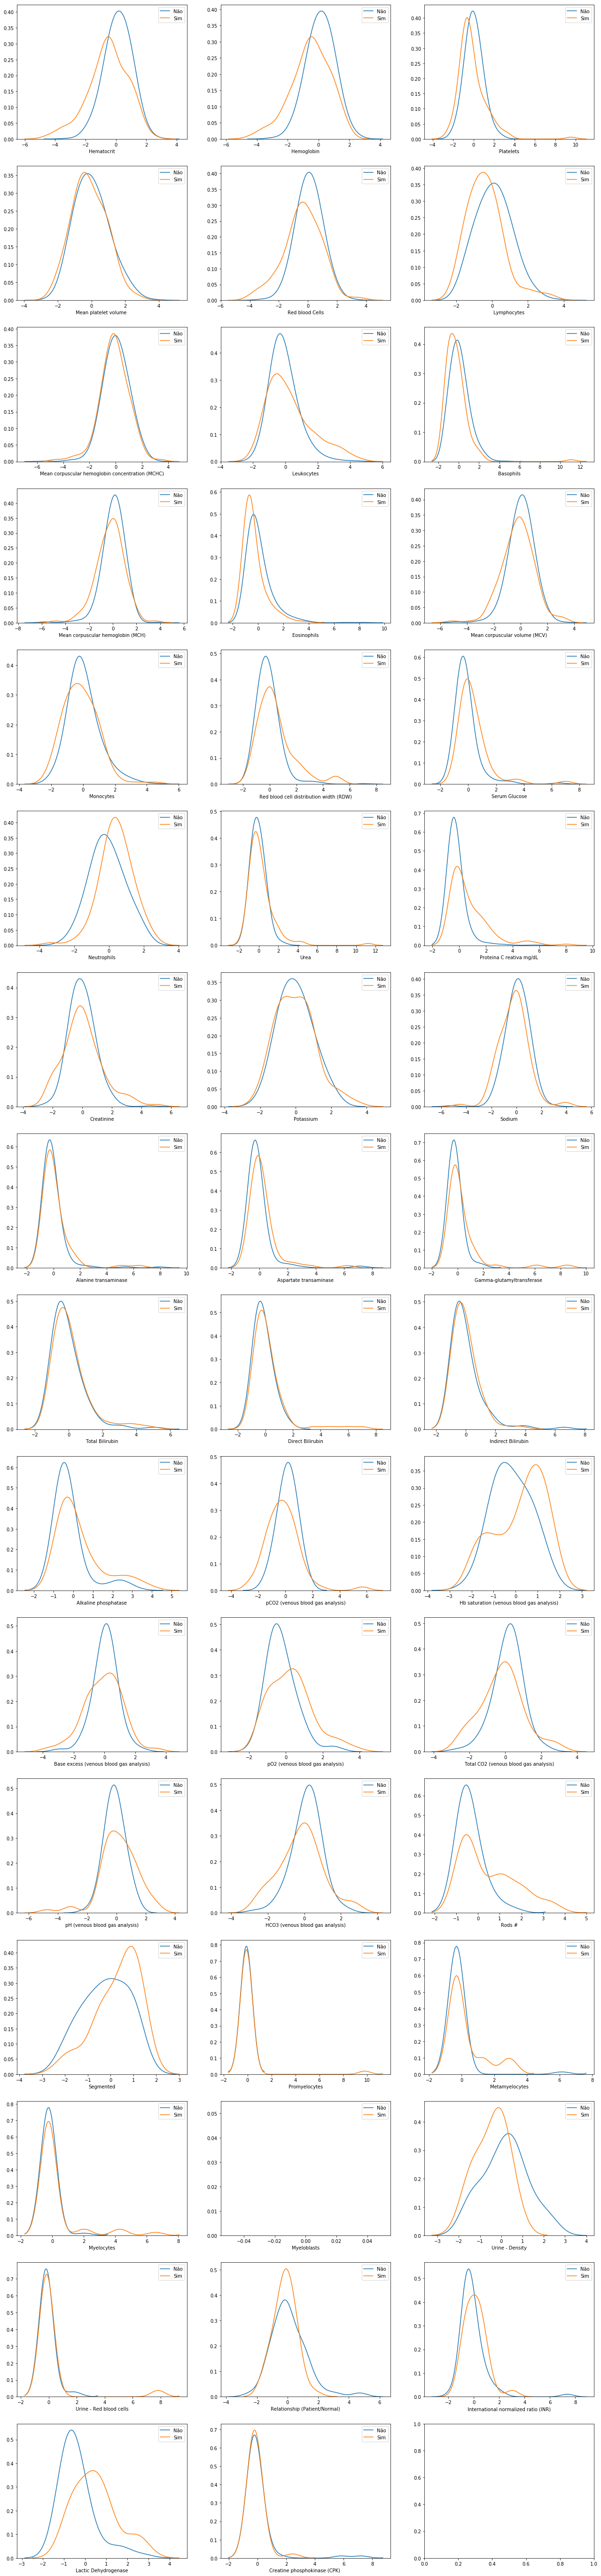

In [6]:
#Plot numerics features 
numerics = ['float32', 'float64']
df2 = df[df['ward_semi_intensive']==0].select_dtypes(include=numerics)
df3 = df[df['ward_semi_intensive']==1].select_dtypes(include=numerics)
fig, ax = plt.subplots(16,3,figsize=(22, 100))
for i, col in enumerate(df2):
    plt.subplot(16,3,i+1)
    plt.xlabel(col, fontsize=10)
    sns.kdeplot(df2[col].values, bw=0.5,label='Não')
    sns.kdeplot(df3[col].values, bw=0.5,label='Sim')
plt.show() 

#Drop null colunms
drop = ['Myeloblasts']
df = df.drop(drop, axis = 1)

# Plotting the frequency of numerics features

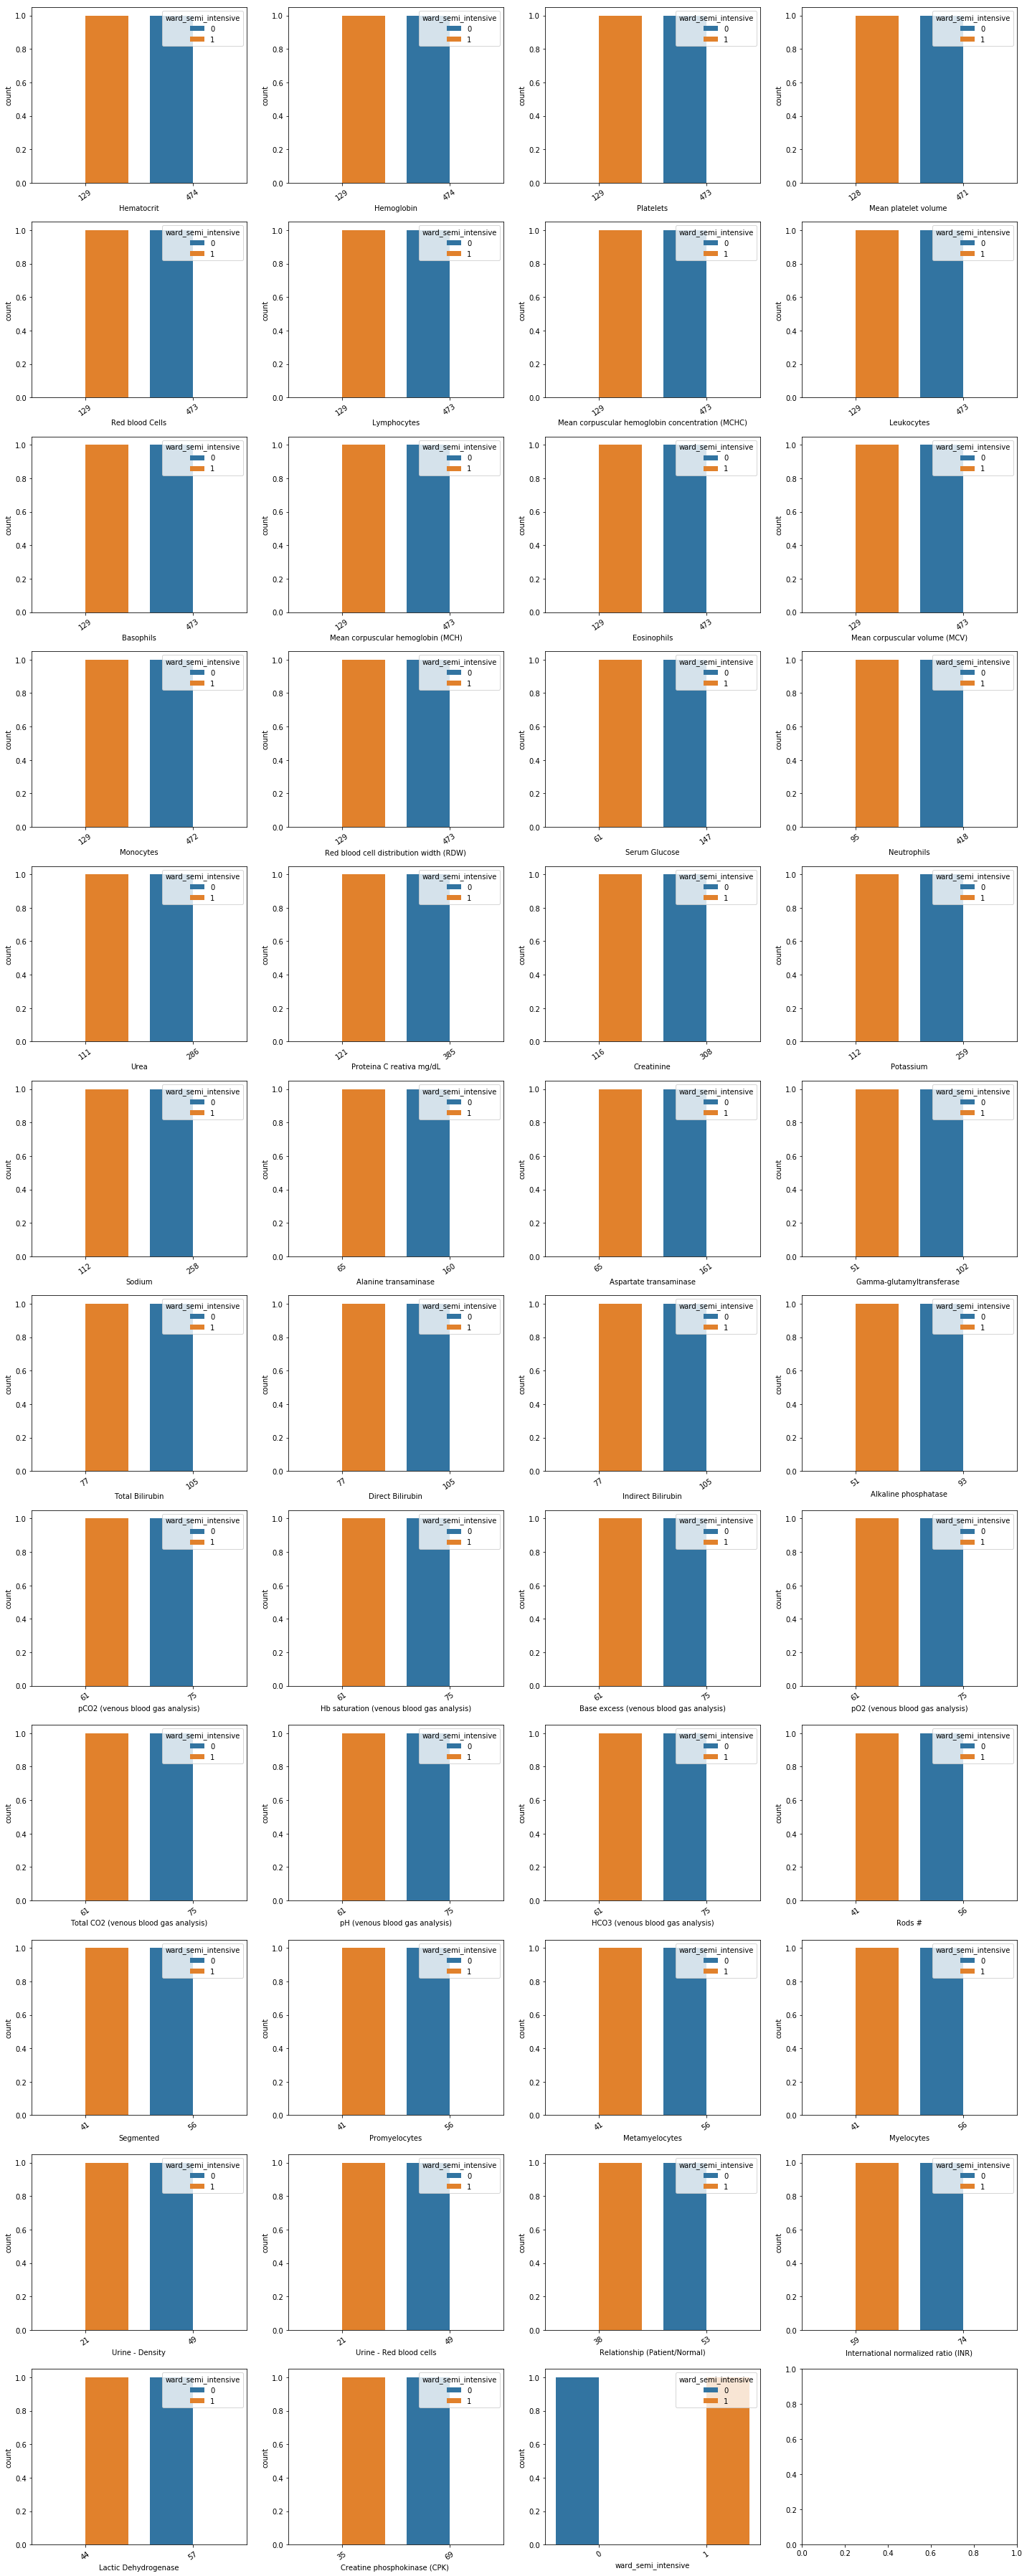

In [7]:
numerics = ['float32', 'float64']
df2 = df[df['ward_semi_intensive']==0].select_dtypes(include=numerics)
df2['ward_semi_intensive'] = 0
df3 = df[df['ward_semi_intensive']==1].select_dtypes(include=numerics)
df3['ward_semi_intensive'] = 1
x = pd.concat([df2,df3])
x = x.groupby('ward_semi_intensive').count()
x['ward_semi_intensive'] = x.index

fig, axes = plt.subplots(round(len(x.columns) / 4), 4, figsize=(20, 50))

for i, ax in enumerate(fig.axes):
    if i < len(x.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=35)
        sns.countplot(x=x.columns[i], data=x,ax=ax,hue='ward_semi_intensive')
fig.tight_layout()


# Plotting the frequency of categorics features  

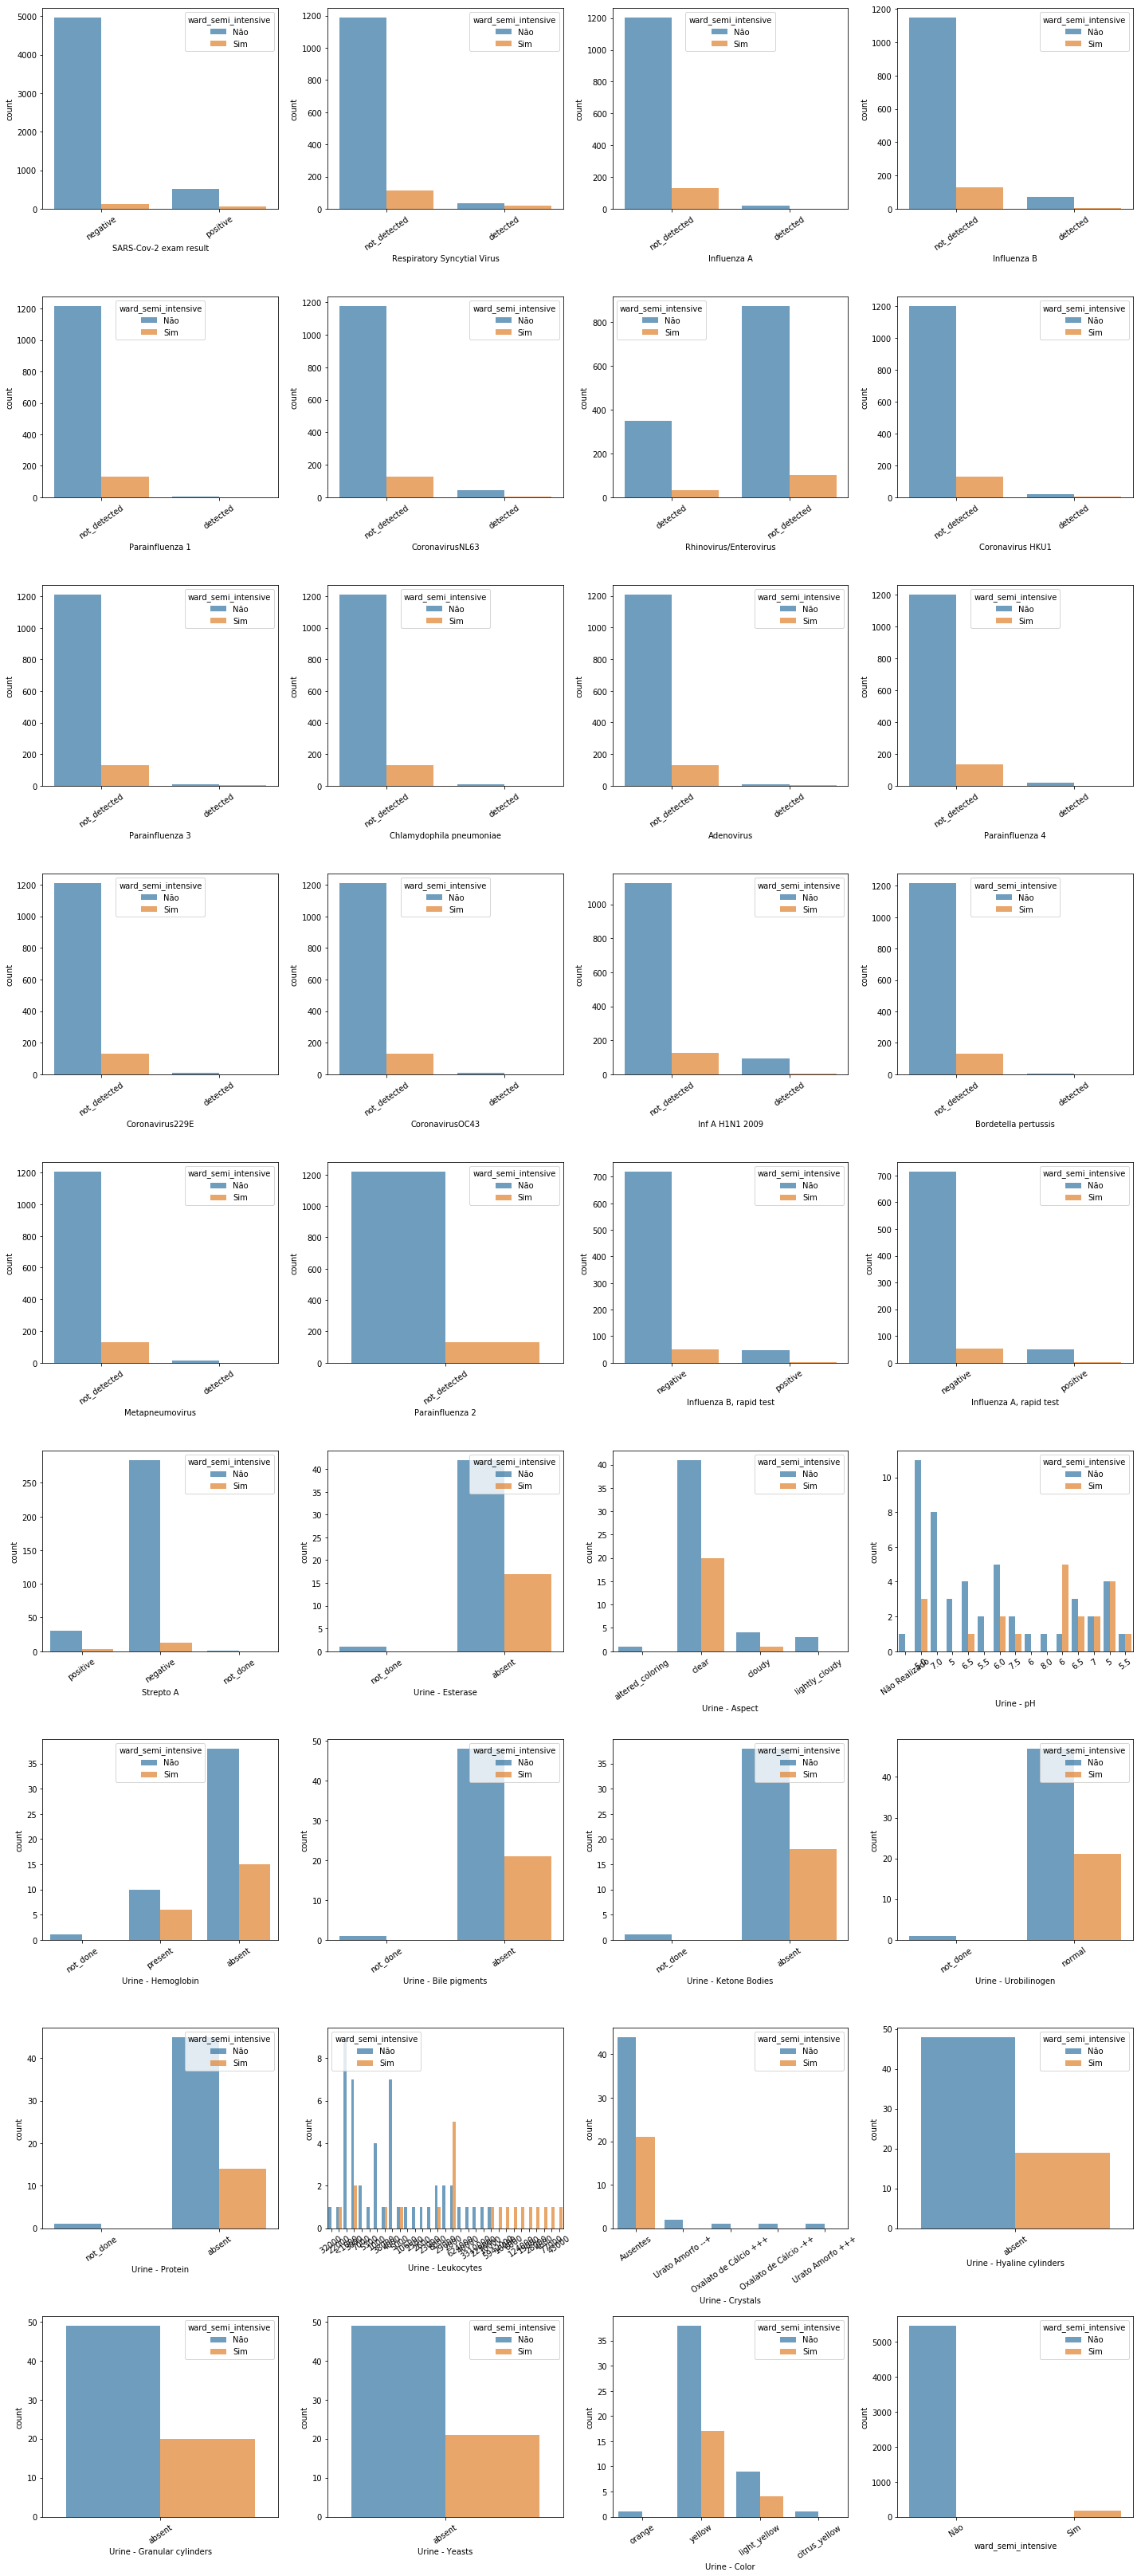

In [8]:
categorics = ['object']
c1 = df[df['ward_semi_intensive']==0].select_dtypes(include=categorics)
c1['ward_semi_intensive'] = 'Não'
c2 = df[df['ward_semi_intensive']==1].select_dtypes(include=categorics)
c2['ward_semi_intensive'] = 'Sim'

c3 = pd.concat([c1,c2])
fig, axes = plt.subplots(round(len(c3.columns) / 4), 4, figsize=(20, 45))

for i, ax in enumerate(fig.axes):
    if i < len(c3.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=35)
        sns.countplot(x=c3.columns[i], alpha=0.7, data=c3, ax=ax,hue="ward_semi_intensive")

fig.tight_layout()

#Drop columns 
drop = ['Adenovirus','Bordetella pertussis', 'Metapneumovirus','Chlamydophila pneumoniae','Inf A H1N1 2009','Urine - Urobilinogen','Urine - Crystals','Urine - Aspect']
df= df.drop(drop,axis=1)

# Data Processing

In [9]:
def detect(x):
    df[x] = np.where(df[x] == "detected",1,0)
    return df[x]   

def positive(x):
    df[x] = np.where(df[x] == "positive",1,0)
    return df[x] 

def absent(x):
    df[x] = np.where(df[x] == "absent",1,0)
    return df[x] 

def present(x):
    df[x] = np.where(df[x] == "present",1,0)
    return df[x] 

#Age quantile
df['age_quantile'] = df['Patient age quantile']
df = df.drop('Patient age quantile',axis=1)

#Detected Respiratory Syncytial Virus'
df['Respiratory Syncytial Virus'] = detect('Respiratory Syncytial Virus')

#Detected rhinovirus/Enterovirus
df['Rhinovirus/Enterovirus'] = detect('Rhinovirus/Enterovirus')

#Detected Influenza A or Influenza B
df['Influenza A'] = detect('Influenza A')
df['Influenza B'] = detect('Influenza B')
df['Influenza A, rapid test'] = positive('Influenza A, rapid test')
df['Influenza B, rapid test'] = positive('Influenza B, rapid test')
df['Influenza_A_or_B'] = np.where((df['Influenza A'] + df['Influenza B'] + df['Influenza A, rapid test'] + df['Influenza B, rapid test']) >= 1,1,0)
df = df.drop(['Influenza A','Influenza B','Influenza A, rapid test','Influenza B, rapid test'],axis=1)

#Positive strepto
df['Strepto A'] = positive('Strepto A')

#Detected any Parainfluenza 
df['Parainfluenza 1'] = detect('Parainfluenza 1')
df['Parainfluenza 2'] = detect('Parainfluenza 2')
df['Parainfluenza 3'] = detect('Parainfluenza 3')
df['Parainfluenza 4'] = detect('Parainfluenza 4')
df['Parainflu_detected'] = np.where((df['Parainfluenza 1']+ df['Parainfluenza 2'] + df['Parainfluenza 3']
                                   + df['Parainfluenza 4']) >= 1,1,0)
df = df.drop(['Parainfluenza 1','Parainfluenza 2','Parainfluenza 3','Parainfluenza 4'],axis=1)

#Detected Alpha coronavirus (Coronavirus229E or CoronavirusNL63)
df['Coronavirus229E'] = detect('Coronavirus229E')
df['CoronavirusNL63'] = detect('CoronavirusNL63')
df['Alpha_coronavirus'] = np.where((df['Coronavirus229E'] + df['CoronavirusNL63'] >= 1),1,0)
df = df.drop(['Coronavirus229E','CoronavirusNL63'],axis=1)

#Detected Beta coronavirus (Coronavirus HKU1 or CoronavirusOC43)
df['Coronavirus HKU1'] = detect('Coronavirus HKU1')
df['CoronavirusOC43'] = detect('CoronavirusOC43')
df['Beta_coronavirus'] = np.where((df['CoronavirusOC43'] + df['Coronavirus HKU1'] >= 1),1,0)
df = df.drop(['CoronavirusOC43','Coronavirus HKU1'],axis=1)

#Positive crovid-19
df['SARS-Cov-2 exam result'] = positive('SARS-Cov-2 exam result')

#Remove text of Urine-Ph columns
df['Urine - pH'] = np.where(df['Urine - pH']=='Não Realizado',np.nan,df['Urine - pH'])
df['Urine - pH'] = df['Urine - pH'].astype(float)

#Absent Urine - Bile pigments
df['Urine_Bile_pigments_absent'] = absent('Urine - Bile pigments')
df = df.drop('Urine - Bile pigments',axis=1)

#Absent 'Urine - Ketone Bodies'
df['Urine_Ketone_Bodies_absent'] = absent('Urine - Ketone Bodies')
df = df.drop('Urine - Ketone Bodies',axis=1)

#Absent  'Urine - Hyaline cylinders'
df['Urine_Hyaline_cylinders_absent'] = absent('Urine - Hyaline cylinders')
df = df.drop('Urine - Hyaline cylinders',axis=1)

#Absent 'Urine - Yeasts'
df['Urine_Yeasts_absent'] = absent('Urine - Yeasts')
df = df.drop('Urine - Yeasts',axis=1)

#Absent 'Urine - Protein'
df['Urine_Protein_absent'] = absent('Urine - Protein')
df = df.drop('Urine - Protein',axis=1)

#Absent 'Urine - Esterase'
df['Urine_Esterase_absent'] = absent('Urine - Esterase')
df = df.drop('Urine - Esterase',axis=1)

#Absent 'Urine -  Granular cylinders'
df['Urine_Granular_cylinders_absent'] = absent('Urine - Granular cylinders')
df = df.drop('Urine - Granular cylinders',axis=1)

#Urine - Leukocytes
df['Urine - Leukocytes'].replace('<', '', regex = True,inplace=True)
df['Urine - Leukocytes'] = df['Urine - Leukocytes'].astype(float)

#Urine - Hemoglobin present and ausent
df['Urine_Hemoglobin_present'] = present('Urine - Hemoglobin')
df['Urine_Hemoglobin_present'] = absent('Urine - Hemoglobin')
df = df.drop('Urine - Hemoglobin',axis=1)

#Urine yellow or light yellow
df['Urine_yellow']= np.where(df['Urine - Color']=='yellow',1,0)
df['Urine_light_yellow']= np.where(df['Urine - Color']=='light_yellow',1,0)
df['Urine_color_yellow'] = np.where(df['Urine_yellow'] + df['Urine_light_yellow'] >=1,1,0)
df = df.drop(['Urine - Color','Urine_yellow','Urine_light_yellow'],axis=1)

#code to fix columns name
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

#Input median in null values 
numerics = ['float32', 'float64']
df2 = df.select_dtypes(include=numerics).apply(lambda x: x.fillna(x.median()),axis=0)

drop_columns = []
for i in df2.columns:
    drop_columns.append(i)
df = df.drop(drop_columns, axis = 1) 

df = pd.concat([df, df2], axis=1, sort=False)
df.head(5)


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,SARS-Cov-2 exam result,Respiratory Syncytial Virus,Rhinovirus/Enterovirus,Strepto A,ward_semi_intensive,age_quantile,Influenza_A_or_B,Parainflu_detected,Alpha_coronavirus,Beta_coronavirus,...,Metamyelocytes,Myelocytes,Urine - pH,Urine - Density,Urine - Leukocytes,Urine - Red blood cells,Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,Creatine phosphokinase (CPK)
0,0,0,0,0,0,13,0,0,0,0,...,-0.315965,-0.233126,6.0,-0.054732,4000.0,-0.193921,-0.089481,-0.156144,-0.33084,-0.22475
1,0,0,1,0,0,17,0,0,0,0,...,-0.315965,-0.233126,6.0,-0.054732,4000.0,-0.193921,-0.089481,-0.156144,-0.33084,-0.22475
2,0,0,0,0,0,8,0,0,0,0,...,-0.315965,-0.233126,6.0,-0.054732,4000.0,-0.193921,-0.089481,-0.156144,-0.33084,-0.22475
3,0,0,0,0,0,5,0,0,0,0,...,-0.315965,-0.233126,6.0,-0.054732,4000.0,-0.193921,-0.089481,-0.156144,-0.33084,-0.22475
4,0,0,1,0,0,15,0,0,0,0,...,-0.315965,-0.233126,6.0,-0.054732,4000.0,-0.193921,-0.089481,-0.156144,-0.33084,-0.22475


In [10]:
#Check and print the correlation between features and target variable1 (top 10 positive correlations)
#Weak positive correlation
df.corr(method='spearman')['ward_semi_intensive'].sort_values(ascending=False).head(11)

ward_semi_intensive                1.000000
Proteina C reativa mg/dL           0.285144
Rods #                             0.282162
Metamyelocytes                     0.227212
Respiratory Syncytial Virus        0.189154
Urine_color_yellow                 0.180071
Urine_Bile_pigments_absent         0.178494
Urine_Yeasts_absent                0.176948
Urine_Ketone_Bodies_absent         0.170619
Urine_Granular_cylinders_absent    0.169060
Urine_Hyaline_cylinders_absent     0.162540
Name: ward_semi_intensive, dtype: float64

### Train/Test Split

In [11]:
#Split feature x and target y 
x = df.drop('ward_semi_intensive',axis=1)
y = df['ward_semi_intensive']

#30% test e 70% train
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

### 1) Random Forest

In [12]:
rf = RandomForestClassifier(max_depth=5, random_state=42,n_estimators=100,class_weight = 'balanced')
rf.fit(x_train,y_train)
p2 = rf.predict(x_test)
print('accuracy:' , accuracy_score(p2,y_test))
print('f1_score:' , f1_score(p2,y_test,average='weighted'))

accuracy: 0.9504132231404959
f1_score: 0.9431452172251361


### 2) Logistic Regression 

In [13]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear',penalty="l1")
lr.fit(x_train,y_train)
p3 = lr.predict(x_test)
print('accuracy:' , accuracy_score(p3,y_test))
print('f1_score:' , f1_score(p3,y_test,average='weighted'))

accuracy: 0.9014167650531287
f1_score: 0.8768970821258404


### 3) Support Vector machine

In [14]:
svm = SVC(gamma='auto',random_state=42)
svm.fit(x_train, y_train)
p5 = svm.predict(x_test)
print('f1_score:' , f1_score(p5,y_test,average='weighted'))
print('accuracy:' , accuracy_score(p5,y_test))


f1_score: 0.9806496958650067
accuracy: 0.9687131050767415


### 4) Xgboost

In [15]:
#Using Xgboost to predict admission to general ward, semi-intensive unit or intensive care 
xgboost = xgb.XGBClassifier(learning_rate = 0.2
                            ,max_depth = 5
                            ,colsample_bytree = 0.9
                            ,n_estimators = 100
                            ,random_state=42
                            ,class_weight='balanced'
                           )

xgboost.fit(x_train,y_train)
p = xgboost.predict(x_test)
print('f1_score:' , f1_score(p,y_test,average='weighted'))
print('accuracy:' , accuracy_score(p,y_test))

f1_score: 0.983355596079561
accuracy: 0.9811097992916175


### 4.1) Tuning Xgboost model 
+ Feature selection
+ Tuning hiper-parameters


##### Feature selection

In [16]:
#Filter feauture with importance > 0.015
feature = []
aux= []
for feature in zip(x_train, xgboost.feature_importances_):
    if feature[1] > 0.015:
        aux.append(feature[0])
        print(feature)

('SARS-Cov-2 exam result', 0.030886801)
('Respiratory Syncytial Virus', 0.01725742)
('Hematocrit', 0.019768747)
('Hemoglobin', 0.035099205)
('Red blood Cells', 0.02301034)
('Lymphocytes', 0.019808738)
('Eosinophils', 0.05993838)
('Red blood cell distribution width (RDW)', 0.035782486)
('Serum Glucose', 0.015996536)
('Proteina C reativa mg/dL', 0.12349428)
('Total Bilirubin', 0.01696619)
('pCO2 (venous blood gas analysis)', 0.053496446)
('Hb saturation (venous blood gas analysis)', 0.062350757)
('Base excess (venous blood gas analysis)', 0.015667053)
('pH (venous blood gas analysis)', 0.031815756)
('Rods #', 0.020474212)
('Segmented', 0.034622055)
('Urine - Red blood cells', 0.021612681)
('Relationship (Patient/Normal)', 0.041834015)
('International normalized ratio (INR)', 0.03546253)
('Lactic Dehydrogenase', 0.0390946)
('Creatine phosphokinase\xa0(CPK)\xa0', 0.016984627)


##### Tuning xgboost hiper-parameters with Random Search

In [17]:
x_train = x_train[aux] 
x_test  = x_test[aux]
def train_model(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    colsample_bytree = params[3]
    n_estimators = params[4]
    
    
    xgboost = xgb.XGBClassifier(learning_rate=learning_rate
                                , num_leaves=num_leaves
                                , min_child_samples=min_child_samples
                                , colsample_bytree=colsample_bytree
                                , n_estimators =  n_estimators
                                , random_state=42
                                ,class_weight='balanced')
    
    xgboost.fit(x_train,y_train)
    
    p = xgboost.predict(x_test)
    
    return -f1_score(p,y_test,average='weighted')

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 50), # num_leaves
         (1, 100), # min_child_samples
         (0.1, 1.0),# colsample bytree
         (100,300)] #n_estimator

result = dummy_minimize(train_model, space, random_state=0, n_calls=100)

#Print Hiper-parameters
print(result.x)

[0.002237781857878498, 29, 52, 0.5168351799911199, 118]


f1_score: 0.9835511231150491
accuracy: 0.9793388429752066
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1671
           1       0.39      0.96      0.56        23

    accuracy                           0.98      1694
   macro avg       0.70      0.97      0.77      1694
weighted avg       0.99      0.98      0.98      1694



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


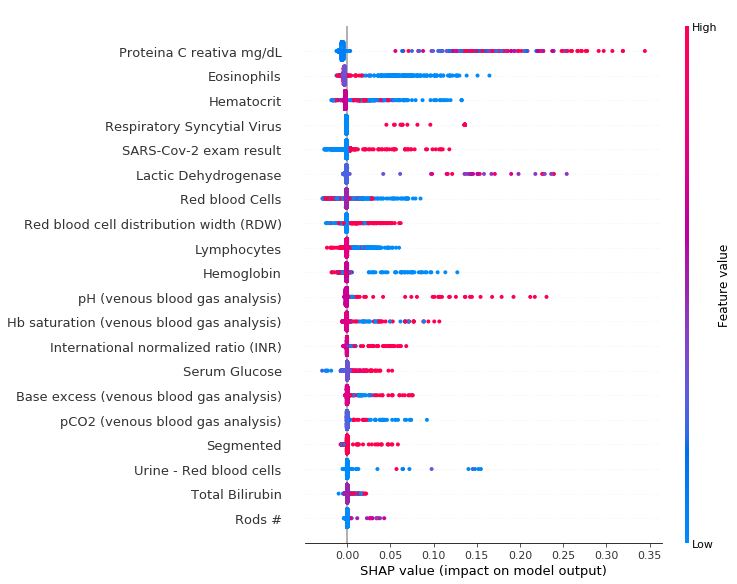

In [18]:
#New Xgboost 
xgboost = xgb.XGBClassifier(learning_rate = 0.002237781857878498
                            ,num_leaves= 29
                            ,min_child_samples = 52
                            ,colsample_bytree = 0.5168351799911199
                            ,n_estimators = 118
                            ,random_state=42
                            ,max_depth = 5
                            ,class_weight='balanced'
                           )

xgboost.fit(x_train,y_train)
p3 = xgboost.predict(x_test)
print('f1_score:' , f1_score(p3,y_test,average='weighted'))
print('accuracy:' , accuracy_score(p3,y_test))
print(classification_report(p3,y_test))
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

### 5) Stacking with VotingClassifier

In [19]:
stacking = VotingClassifier(estimators=[
    ('rf', rf), ('lr',lr),('xgboost',xgboost),('svm',svm)], voting='hard')
stacking.fit(x_train, y_train)
p4 = stacking.predict(x_test)
print('f1_score:' , f1_score(p4,y_test,average='weighted'))
print('accuracy:' , accuracy_score(p4,y_test))
print(classification_report(p4,y_test))

f1_score: 0.983846251582868
accuracy: 0.9799291617473436
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1670
           1       0.41      0.96      0.57        24

    accuracy                           0.98      1694
   macro avg       0.71      0.97      0.78      1694
weighted avg       0.99      0.98      0.98      1694



### 6)  final machine learning model: Stacking

In [20]:
print('f1_score:' , f1_score(p4,y_test,average='weighted'))
print('accuracy:' , accuracy_score(p4,y_test))

f1_score: 0.983846251582868
accuracy: 0.9799291617473436
